# <center> Classification des styles artistiques 

### 1. Préparation des données

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import src.ml_utils as ml

from importlib import reload
reload(ml);

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC

In [2]:
#On transforme en dataframe le CSV de la partie vision
df_vision = pd.read_csv("../results/CSV/dataset_vision_features.csv")

### 2. Entrainement du SVM uniquement avec les caractéristiques issues de la vision ou fréquentielles 
(sans la caractéristique "genre")

On va d'abord trouver le meilleur SVM pour notre dernier CSV fréquence qui contient 19 caractéristiques

In [4]:
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features_minimal.csv" #CSV avec 19 caractéristiques 
)

# Création de l'objet de split pour le GridSearchCV
ps = PredefinedSplit(test_fold=fold)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Lancement du GridSearchCV pour le fichier csv avec 19 caractéristiques fréquentielles...")
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=ps, verbose=2, n_jobs=-1)

grid.fit(X_combined, y_combined)

print("-" * 30)
print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleur score en Validation : {grid.best_score_:.2%}")
test_score = grid.score(X_test_s, y_test)
print(f"Score final sur le TEST : {test_score:.2%}")

Lancement du GridSearchCV pour le fichier csv avec 19 caractéristiques fréquentielles...
Fitting 1 folds for each of 16 candidates, totalling 16 fits
------------------------------
Meilleurs paramètres : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score en Validation : 28.91%
Score final sur le TEST : 29.03%


In [5]:
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features.csv" #CSV avec 47 caractéristiques 
)

# Création de l'objet de split pour le GridSearchCV
ps = PredefinedSplit(test_fold=fold)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Lancement du GridSearchCV pour le fichier csv avec 47 caractéristiques fréquentielles...")
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=ps, verbose=2, n_jobs=-1)

grid.fit(X_combined, y_combined)

print("-" * 30)
print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleur score en Validation : {grid.best_score_:.2%}")
test_score = grid.score(X_test_s, y_test)
print(f"Score final sur le TEST : {test_score:.2%}")

Lancement du GridSearchCV pour le fichier csv avec 47 caractéristiques fréquentielles...
Fitting 1 folds for each of 16 candidates, totalling 16 fits
------------------------------
Meilleurs paramètres : {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Meilleur score en Validation : 30.30%
Score final sur le TEST : 31.42%


Les meilleurs performances se font avec le dataset avec les 47 caractéristqiques fréquentielles et les caractéristiques issues de la vision.   
Affichons ses résultats :

 Résultats pour le SVM sur les caractéristiques vision et fréquence
Précision Globale (Accuracy) : 31.42%
F1-Score Global (Weighted)   : 31.10%

--- Rapport de Performance détaillé ---
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.20      0.27      0.23        49
               Art_Nouveau       0.14      0.15      0.14        55
                   Baroque       0.31      0.37      0.34        60
      Color_Field_Painting       0.48      0.53      0.50        51
      Contemporary_Realism       0.27      0.28      0.27        57
                    Cubism       0.28      0.28      0.28        60
         Early_Renaissance       0.43      0.41      0.42        70
             Expressionism       0.09      0.10      0.10        58
                   Fauvism       0.20      0.29      0.24        55
          High_Renaissance       0.36      0.45      0.40        58
             Impressionism       0.24      0.26      0.25        6

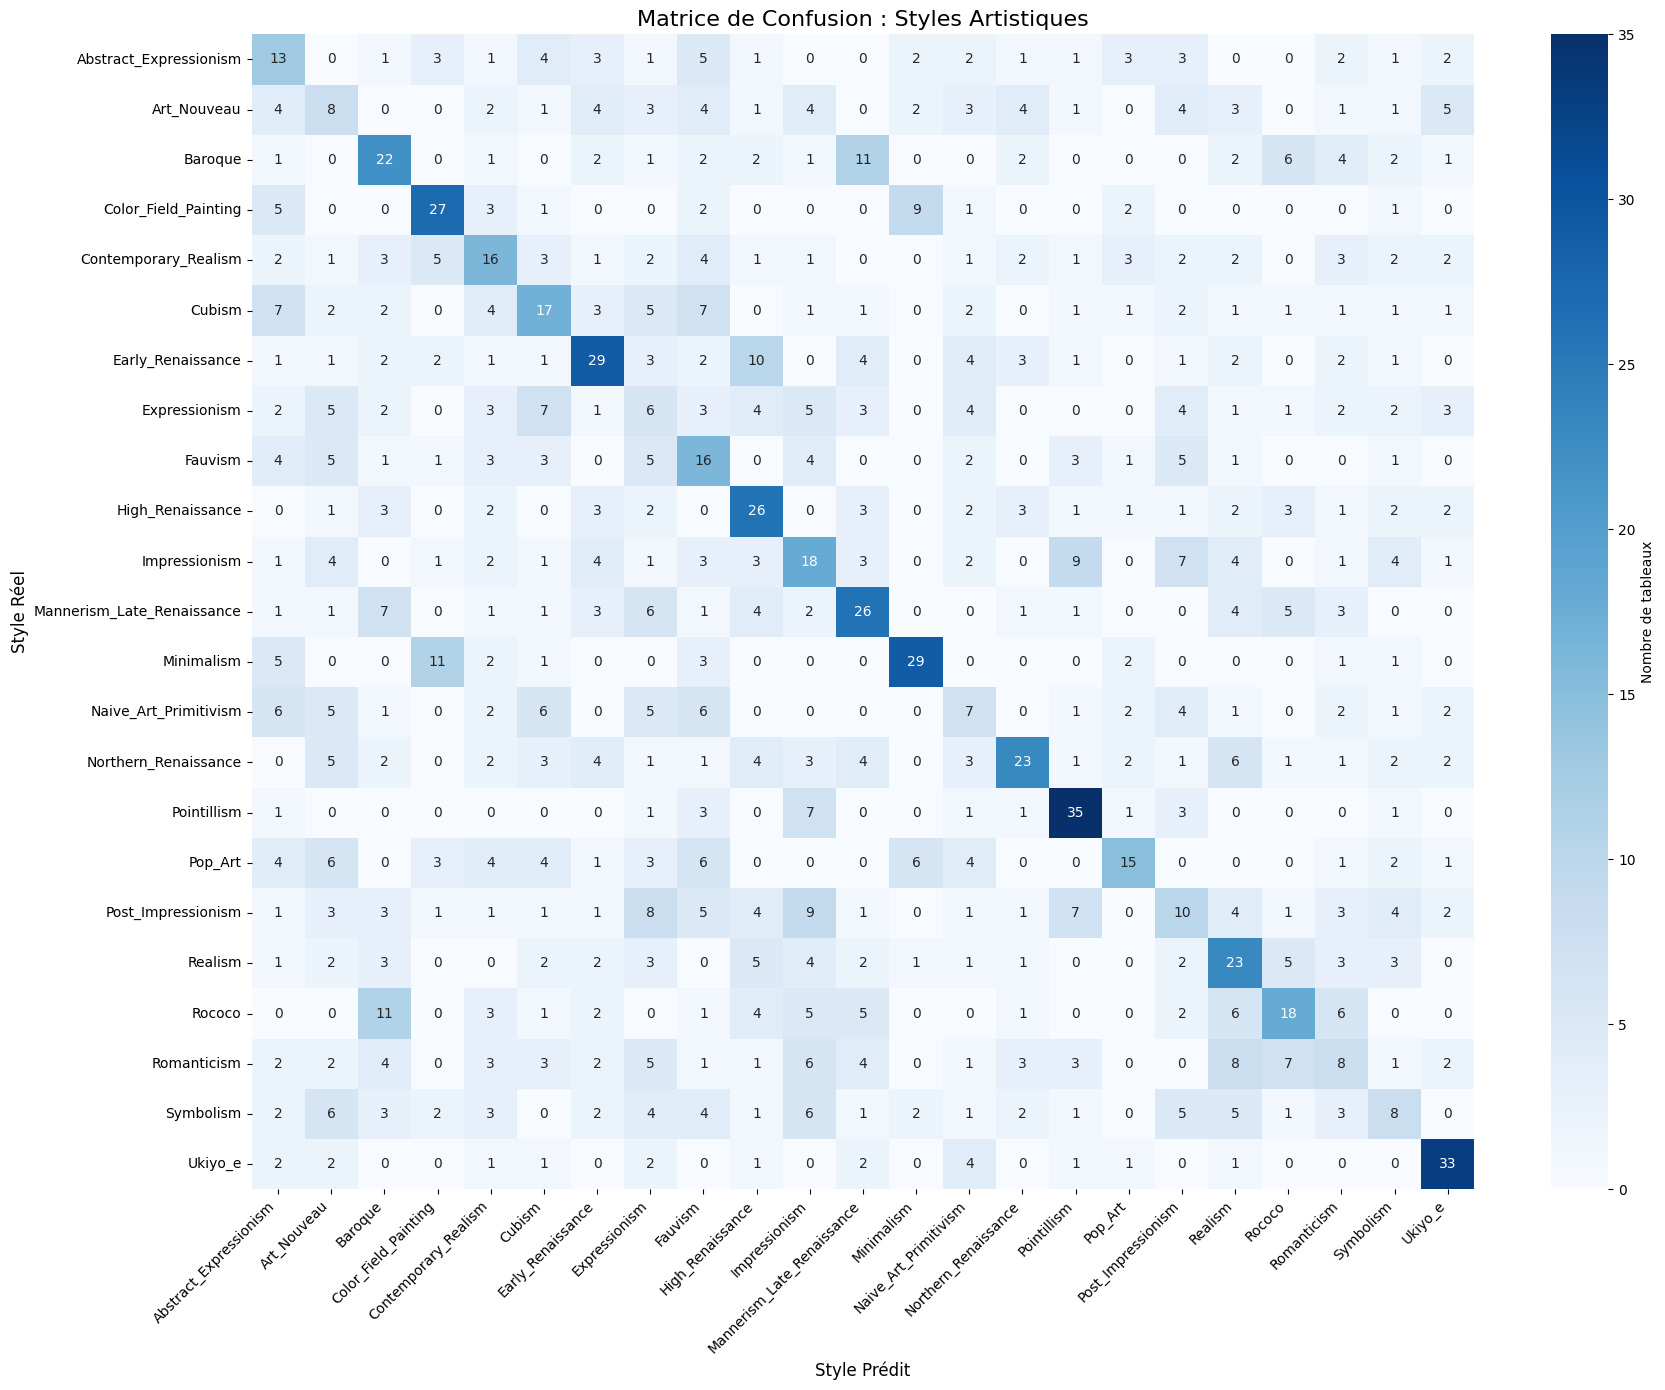

In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = grid.predict(X_test_s) 

# Calcul des métriques globales
acc = accuracy_score(y_test, y_pred)
f1_glob = f1_score(y_test, y_pred, average='weighted')

print(f" Résultats pour le SVM sur les caractéristiques vision et fréquence")

print(f"Précision Globale (Accuracy) : {acc:.2%}")
print(f"F1-Score Global (Weighted)   : {f1_glob:.2%}")

# Analyse détaillée par style
print("\n--- Rapport de Performance détaillé ---")
print(classification_report(y_test, y_pred))

# Analyse visuelle
import src.ml_utils as ml
ml.plot_art_confusion_matrix(y_test, y_pred)

#### 2. Entrainement du SVM avec les caractéristiques issues de la vision ou fréquentielles avec la caractéristique "genre"

### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrainement 
rf_model = RandomForestClassifier(n_estimators=500, 
                                  class_weight='balanced', 
                                  random_state=42,
                                  n_jobs=-1) # Utilise tous tes processeurs

rf_model.fit(X_train_scaled, y_train)

# Prédiction
y_pred_rf = rf_model.predict(X_test_scaled)

In [ ]:
# 3. MÉTRIQUES DE PERFORMANCE
print(f"Précision Globale RF : {accuracy_score(y_test, y_pred_rf):.2%}")
print("\n--- Rapport détaillé par Style (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

# 4. MATRICE DE CONFUSION
ml.plot_art_confusion_matrix(y_test, y_pred_rf)

In [ ]:

# 5. IMPORTANCE DES FEATURES
# On récupère les noms des colonnes depuis le DataFrame X_train original
feature_names = X_train.columns
ml.plot_feature_importance(rf_model, feature_names)